# Librerias

In [ ]:
import matplotlib.pyplot as plt
import os

# Números y Datos
import numpy as np

import networkx as nx

from networkx.algorithms.approximation import average_clustering

import community.community_louvain as cl


import pickle

# Bajar Datos

In [ ]:
# DATOS REDES:
!wget -O airport.txt https://www.dropbox.com/scl/fi/nk8yvhez5ylhd6blzf77o/airport.txt?rlkey=3cf24r6yij8uu0fakb68yztlm&dl=1
!wget -O facebook.txt https://www.dropbox.com/scl/fi/hdgcmyss47w9t676kh2ug/facebook.txt?rlkey=j616y86ejfn6f719jg4b8e413&dl=1
!wget -O lesmiserables.txt https://www.dropbox.com/scl/fi/ex7183k4zjgxbiw0diwi3/lesmiserables.txt?rlkey=zx5u5371s7gw3jlv50363jycf&dl=1
!wget -O terrorist.txt https://www.dropbox.com/scl/fi/2vl6hcazv5v13r7scodod/terrorist.txt?rlkey=l0n1rxbby6a8irtlyh1tbbweo&dl=1
!wget -O celegans.txt https://www.dropbox.com/scl/fi/t62q9swnah7nvu34falkj/celegans.txt?rlkey=lxg2kashijntfi0bwmeuty5ja&dl=1
!wget -O email.txt https://www.dropbox.com/scl/fi/w5o34b0olg7xek4s42lml/email-Eu-core.txt?rlkey=g2561imdd4ssyrwfgywrotzwm&st=czqgmef0&dl=1
!wget -O email_labels.txt  https://www.dropbox.com/scl/fi/ij3b6jul7ispiovt18sfm/email-Eu-core-department-labels.txt?rlkey=dqp60qw20pw7biil9cvti4u68&st=zij9wsi8&dl=1


# AHORA ARCHIVOS DE POSICION DE LOS NODOS:
!wget -O airportStronglyConn_pos.pkl https://www.dropbox.com/scl/fi/eebzjgqazi8b02bkkrxmf/airStrongly_positions.pkl?rlkey=cyhifzsgrls5vdlycrb1gnykv&st=6lozmqe6&dl=1
!wget -O email_pos.pkl https://www.dropbox.com/scl/fi/loeuul6gxq7uscd1m7ks8/email_positions.pkl?rlkey=caf194s8198pffo2zaq6767jz&st=kw0c3tu4&dl=1
!wget -O fb_pos.pkl https://www.dropbox.com/scl/fi/ka6v0h9ew5j08haxlbf6b/fb_positions.pkl?rlkey=7ul7jr7re5bziy54cgp3x9tre&st=vp6gjciw&dl=1

--2024-05-10 19:28:07--  https://www.dropbox.com/scl/fi/nk8yvhez5ylhd6blzf77o/airport.txt?rlkey=3cf24r6yij8uu0fakb68yztlm
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uccabb09df8c186d89da6cc404c2.dl.dropboxusercontent.com/cd/0/inline/CSpPKUg5vDVVPuQuS-STpAsdbSSOOY7-qTbP2n1KUT8JhAbSrbVLkjPYP4HJUzg65GJB1XHN6Sh2oemfpoOzy59vQPafzStGxBJdsZ6yKnCQ7OA76G0qFPTrBIIZhOIlauEiNPdgLMtG-5eUE6yUvL3z/file# [following]
--2024-05-10 19:28:08--  https://uccabb09df8c186d89da6cc404c2.dl.dropboxusercontent.com/cd/0/inline/CSpPKUg5vDVVPuQuS-STpAsdbSSOOY7-qTbP2n1KUT8JhAbSrbVLkjPYP4HJUzg65GJB1XHN6Sh2oemfpoOzy59vQPafzStGxBJdsZ6yKnCQ7OA76G0qFPTrBIIZhOIlauEiNPdgLMtG-5eUE6yUvL3z/file
Resolving uccabb09df8c186d89da6cc404c2.dl.dropboxusercontent.com (uccabb09df8c186d89da6cc404c2.dl.dropboxusercontent.com)... 162.125.8.15, 2620:10

# Funciones útiles

**Para cargar datos**

In [ ]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G


def read_graph_weighted(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

def read_dir_graph(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_dir_graph_weighted(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

In [ ]:
def get_graph_pos(filename):
  with open(filename, 'rb') as f:
    posData = pickle.load(f)
  return posData

**Borrarle los pesos a un grafo pesado**

In [ ]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

**Para calcular eficientemente en grafos muy grandes una aproximación a distancias mínimas medias, $<d>$**

In [ ]:
def sample_path_lengths(G, nodes=None, trials=1000):
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

# Preludio

**Veamos características de las redes**

In [ ]:
fb = read_graph('facebook.txt')
print('Facebook')
print(fb)
print('Es dirigido?:',nx.is_directed(fb))
print('Es pesado?:',nx.is_weighted(fb))
print('Es conectado?:',nx.is_connected(fb))
print('')

email = read_graph('email.txt')
print('Email')
print(email)
print('Es dirigido?:',nx.is_directed(email))
print('Es pesado?:',nx.is_weighted(email))
print('Es conectado?:',nx.is_connected(email))
print('')

terr= read_graph_weighted('terrorist.txt')
print('Terrorist')
print(terr)
print('Es dirigido?:',nx.is_directed(terr))
print('Es pesado?:',nx.is_weighted(terr))
print('Es conectado?:',nx.is_connected(terr))
print('')

lesmis= read_graph_weighted('lesmiserables.txt')
print('Les Miserables')
print(lesmis)
print('Es dirigido?:',nx.is_directed(lesmis))
print('Es pesado?:',nx.is_weighted(lesmis))
print('Es conectado?:',nx.is_connected(lesmis))
print('')

celegans= read_graph_weighted('celegans.txt')
print('C. elegans')
print(celegans)
print('Es dirigido?:',nx.is_directed(celegans))
print('Es pesado?:',nx.is_weighted(celegans))
print('Es conectado?:',nx.is_connected(celegans))
print('')

air = read_dir_graph_weighted('airport.txt')
print('Airport')
print(air)
print('Es dirigido?:',nx.is_directed(air))
print('Es pesado?:',nx.is_weighted(air))
print('Es fuertemente conexo?:',nx.is_strongly_connected(air))
print('Es debilmente conexo?:',nx.is_weakly_connected(air))






Facebook
Graph with 4039 nodes and 88234 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True

Email
Graph with 1005 nodes and 16706 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: False

Terrorist
Graph with 64 nodes and 243 edges
Es dirigido?: False
Es pesado?: True
Es conectado?: True

Les Miserables
Graph with 77 nodes and 254 edges
Es dirigido?: False
Es pesado?: True
Es conectado?: True

C. elegans
Graph with 297 nodes and 2148 edges
Es dirigido?: False
Es pesado?: True
Es conectado?: True

Airport
DiGraph with 1574 nodes and 28236 edges
Es dirigido?: True
Es pesado?: True
Es fuertemente conexo?: False
Es debilmente conexo?: False


¿Cómo eliminarle los pesos a un grafo pesado?:

In [ ]:
celegansU = celegans.copy()
drop_weights(celegansU)
print('C. elegans (unweighted)')
print(celegansU)
print('Es dirigido?:',nx.is_directed(celegansU))
print('Es pesado?:',nx.is_weighted(celegansU))
print('Es conectado?:',nx.is_connected(celegansU))
print('')

C. elegans (unweighted)
Graph with 297 nodes and 2148 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True



Vamos a leer los labels del dataset $Email$ (a qué departamento pertenece cada nodo):

In [ ]:
array = np.loadtxt('email_labels.txt', dtype=int)
labelsEmail=list(array[:,1])
print(labelsEmail) # es una lista donde de label para cada nodo (por ej. el nodo 3 pertenece al departamento 21

[1, 1, 21, 21, 21, 25, 25, 14, 14, 14, 9, 14, 14, 26, 4, 17, 34, 1, 1, 14, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 5, 34, 14, 14, 17, 17, 10, 10, 36, 37, 5, 7, 4, 22, 22, 21, 21, 21, 21, 7, 7, 36, 21, 25, 4, 8, 15, 15, 15, 37, 37, 9, 1, 1, 10, 10, 3, 3, 3, 29, 15, 36, 36, 37, 1, 36, 34, 20, 20, 8, 15, 9, 4, 5, 4, 20, 16, 16, 16, 16, 16, 38, 7, 7, 34, 38, 36, 8, 27, 8, 8, 8, 10, 10, 13, 13, 6, 26, 10, 1, 36, 0, 13, 16, 16, 22, 6, 5, 4, 0, 28, 28, 4, 2, 13, 13, 21, 21, 17, 17, 14, 36, 8, 40, 35, 15, 23, 0, 0, 7, 10, 37, 27, 35, 35, 0, 0, 19, 19, 36, 14, 37, 24, 17, 13, 36, 4, 4, 13, 13, 10, 4, 38, 32, 32, 4, 1, 0, 0, 0, 7, 7, 4, 15, 16, 40, 15, 15, 15, 15, 0, 21, 21, 21, 21, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 22, 19, 19, 22, 34, 14, 0, 1, 17, 37, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 23, 0, 4, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 10, 14, 14, 1, 14, 7, 13, 20, 31, 40, 6, 4, 0, 8, 9, 9, 10, 0, 10, 14, 14, 14, 14, 39, 17, 4, 28, 17, 17, 17

**Componentes conectados en grafos dirigidos**  ❗

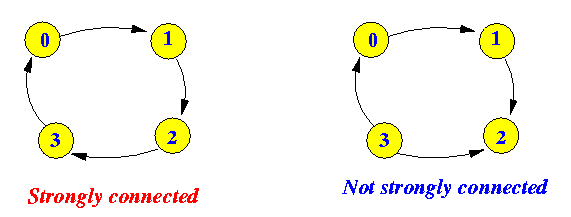

**Componente Fuertemente Conexa (Strongly Connected):**

1.   Desde cada nodo de la componente existe un camino hacia todos los otros nodos que usa aristas únicamente de la componente.
2.   No hay un nodo del grafo fuera de la componente desde el cual se pueda llegar a la componente y al que se pueda llegar desde ella (si existiera estaría en la componente).

**Componente Débilmente Conexa (Weakly Connected):**


1.  Si al convertir el grafo dirigido en uno no dirigido el grafo resultante es conexo.



**¿Cómo medir distancias en grafos dirigidos?**

1.   Si es un componente fuertemente conexo puedo medir $<d>$ normalmente (con nx.average_shortest_path_length o con estimate_path_length si el grafo es muy grande)
2.   Si es un componente debilmente conexo no puedo medir $<d>$. Primero debo transformar el componente a un grafo no dirigido (con nx.DiGraph.to_undirected) y ahí si medir $<d>$. Pero tomar en cuenta que vamos a haber perdido la información de la direccionalidad.

Observación: para grafos dirigidos la eficiencia global $eff$ (nx.global_efficiency) no está definida.






¿Cómo son los componentes de nuestras redes dirigidas?

In [ ]:
airStronglyCC = sorted(nx.strongly_connected_components(air), key=len, reverse=True)
airStrongly = air.subgraph(airStronglyCC[0])
print('Airport componente gigante fuertemente conexa')
print(airStrongly)
print('Es dirigido?:',nx.is_directed(airStrongly))
print('Es pesado?:',nx.is_weighted(airStrongly))
print('Es fuertemente conexo?:',nx.is_strongly_connected(airStrongly))
print('Es debilmente conexo?:',nx.is_weakly_connected(airStrongly))
print('')



Airport componente gigante fuertemente conexa
DiGraph with 1402 nodes and 28032 edges
Es dirigido?: True
Es pesado?: True
Es fuertemente conexo?: True
Es debilmente conexo?: True



¿Cuál es la componente gigante del grafo Email?

In [ ]:
G=email
G.remove_edges_from(nx.selfloop_edges(G)) # Borro autoenlaces
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
emailGiant = G.subgraph(Gcc[0])
print(emailGiant)
print('Es dirigido?:',nx.is_directed(emailGiant))
print('Es pesado?:',nx.is_weighted(emailGiant))
print('Es conectado?:',nx.is_connected(emailGiant))
print('')

Graph with 986 nodes and 16064 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True



Si quiero obtener la versión no dirigda de un grafo dirigido, hago esto:

In [ ]:

airUndir=nx.DiGraph.to_undirected(air)




**¿Cómo lidar con grafos muy grandes?**

**Camino mínimo medio**

Para grafos no pesados (dirigdos o no dirigidos), el algoritmo que usa la librería Networkx es [Breadth-first search](https://en.wikipedia.org/wiki/Breadth-first_search), que escalea $O(nodos+enlaces)$

Para grafos pesados (no dirigidos), el algoritmo que se usa es el de [Dijkstra](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm), que escalea $O(nodos^2)$. Si el grafo es dirigo usa una variante del algoritmo (de Fredman & Tarjan) que escalea $O(enlaces+nodos \log(nodos))$



In [ ]:
print('Dos cálculos de caminos mínimos medios')
## DISTANCIAS
# ESTO DEMORA MAS DE 1 MINUTO
print(nx.average_shortest_path_length(fb))

# ESTO DEMORA MENOS DE 1 SEGUNDO
print(estimate_path_length(fb))
print('')

print('Dos cálculos de coeficiente de clustering medio')
## COEFICIENTE DE CLUSTERING
# ESTO DEMORA 4 SEGUNDOS
print(nx.average_clustering(fb))

# ESTO MENOS DE 1 SEGUNDO
print(average_clustering(fb, trials=1000))

Dos cálculos de caminos mínimos medios
3.6925068496963913
3.7

Dos cálculos de coeficiente de clustering medio
0.6055467186200876
0.603


### Spring Layout: posición espacial de los nodos en el grafo
Para graficar grafos, es útil usar el layout de "resortes" para encontrar una posición espacial "óptima" de los nodos ("óptima" en el sentido que representa mejor la organización general del grafo).

Para obtener este layout, se considera una lucha entre dos fuerzas antagónicas: una en la que los nodos se "repelen" entre sí, y otra en la que los pares de nodos conectados se acercan gracias a los enlaces que los unen (que funcionan como "resortes"). De esta manera los nodos más interconectados van a agruparse en una posición espacial del grafo. La simulación corre un número de iteriaciones (controlada por el parámetro $iterations$) hasta llegar a un equilibrio.

*Opcional:* un parámetro extra opcional, el parámetro $k$, que fuerza una distancia óptima entre nodos (cuanto menor más se agrupan todos los nodos en el centro; si lo agrando va a posicionar los nodos menos conectados más en la periferia del grafo). Esto serviría si luego de correr la simulación, el layout resultante es una bola de nodos en el centro. En ese caso hay que probar a mano con varios valores de $k$ (en el rango 0.1 - 10, por ejemplo) para ver si mejora el layout.

In [ ]:
# Se corre así para un grafo "G", y me devuelve un diccionario "pos" de posiciones
pos = nx.spring_layout(G,iterations=1000)

# Opcional, con parámetro "k"
# pos = nx.spring_layout(G,iterations=1000, k=0.5)

Para grafos muy grandes puede demorar (por ej., 20 mins para el grafo de Facebook), así que estas son las posiciones pre-computadas (con $iterations$=1000 y $k$=None):

In [ ]:
pos_email=get_graph_pos('email_pos.pkl')
pos_fb=get_graph_pos('fb_pos.pkl')
pos_airSC=get_graph_pos('airportStronglyConn_pos.pkl')

Calculo de antemano las posiciones para el resto de los grafos:

In [ ]:
pos_terr = nx.spring_layout(terr,iterations=1000)
pos_lesmis = nx.spring_layout(lesmis,iterations=1000)
pos_cel = nx.spring_layout(celegans,iterations=1000)


### ¿Cómo graficar redes pesadas?
Ahora defino una función útil para graficar redes pesadas donde el ancho de los enlaces es proporcional al peso. Puede ser un proceso lento si el grafo es demasiado grande (en ese caso usar nx.draw como siempre y no darle diferentes anchos a los enlaces).

El parametro $magnification$ calibra cuanto se suaviza o exagera la diferencia entre los anchos de los enlaces.
El parámetro $colorMapping$ es un diccionario donde a cada nodo se le asigna un valor numérico que se puede mapear a un color. Por ej., puede ser la centralidad de un nodo, que se va a representar en una escala de colores

In [ ]:
def plotWeightedGraph(G,pos,colorMapping,magnification,nodeSize=45):
  values = [v for n,v in colorMapping.items()]
  nx.draw_networkx_nodes(G,pos=pos,node_size=nodeSize, node_color = values)
  nx.draw_networkx_labels(G,pos,{n:n for n in G.nodes()},font_size=7,font_color='white')

  edge_weights = nx.get_edge_attributes(G, "weight")
  edgeWidths=np.array(list(edge_weights.values()))
  edgeWidths=magnification*edgeWidths/np.max(edgeWidths)
  edgeWidths[edgeWidths>0]=edgeWidths[edgeWidths>0]-np.min(edgeWidths[edgeWidths>0])+.5

  nx.draw_networkx_edges(G, pos, edgelist=G.edges(),width=edgeWidths,edge_color='gray')


Por ejemplo, para el dataset *Terroristas*:



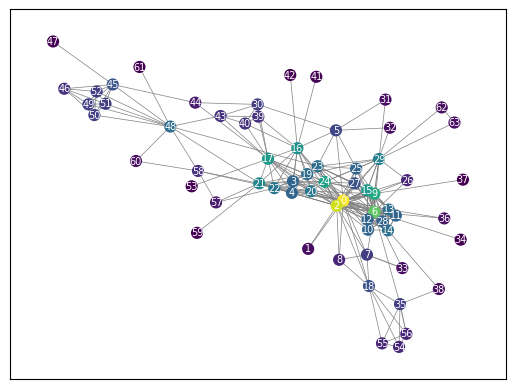

In [ ]:
G=terr
centrality = nx.degree_centrality(G)
magnification=1
nodeSize=60
plotWeightedGraph(G,pos_terr,centrality,magnification,nodeSize)

### ¿Cómo resaltamos un atributo de un nodo (por ej., centralidad) al graficar un grafo?

In [ ]:
def plotNodeAttribute(G,pos,attribute,exaggeration):
  values = [v for n,v in attribute.items()]
  nsize = np.array (values)
  nsize = exaggeration*( nsize - min(nsize))/(max(nsize) - min(nsize))
  nx.draw(G,pos=pos, node_size = nsize, alpha=0.4,node_color = values, edge_color='gray')

Por ejemplo, para el dataset *Terroristas* (obviando el peso de los enlaces):


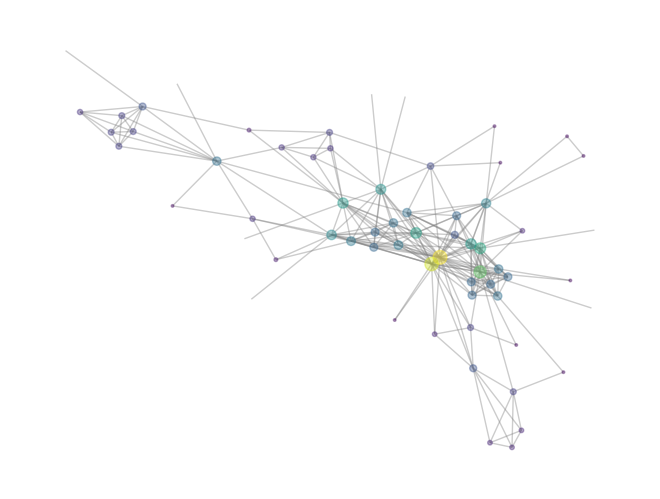

In [ ]:
exaggeration=100
plotNodeAttribute(G,pos_terr,centrality,exaggeration)